## In this notebook, I will describe how the model behave with Titanic data.

## 1. Preprocessing data

In [1]:
# pip install -U shap

In [2]:
pip show shap

Name: shapNote: you may need to restart the kernel to use updated packages.

Version: 0.39.0
Summary: A unified approach to explain the output of any machine learning model.
Home-page: http://github.com/slundberg/shap
Author: Scott Lundberg
Author-email: slund1@cs.washington.edu
License: MIT
Location: c:\users\tomoyuki.kawashita\anaconda3\lib\site-packages
Requires: pandas, numpy, numba, cloudpickle, scipy, slicer, scikit-learn, tqdm
Required-by: shapash


In [3]:
import pandas as pd
import numpy as np
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")

train.head()
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
alldata = pd.concat([train, test],axis=0)

In [5]:
def get_title(name):
    if '.' in name:
        return name.split(',')[1].split('.')[0].strip()
    else:
        return 'Unknown'
    
def replace_titles(x):
    title = x['Title']
    if title in ['Capt', 'Col', 'Don', 'Jonkheer', 'Major', 'Rev', 'Sir']:
        return 'Mr'
    elif title in ['the Countess', 'Mme', 'Lady']:
        return 'Mrs'
    elif title in ['Mlle', 'Ms']:
        return 'Miss'
    elif title =='Dr':
        if x['Sex']=='male':
            return 'Mr'
        else:
            return 'Mrs'
    else:
        return title

In [6]:
alldata['Title'] = alldata['Name'].map(lambda x: get_title(x))
alldata['Title'] = alldata.apply(replace_titles, axis=1)

In [7]:
alldata=alldata.drop(["PassengerId","Name","Ticket","Cabin"],axis=1)
alldata=pd.get_dummies(alldata, drop_first=True) #To avoid Multicollinearity, add drop_first=True
alldata.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_male,Embarked_Q,Embarked_S,Title_Master,Title_Miss,Title_Mr,Title_Mrs
0,0.0,3,22.0,1,0,7.2500,1,0,1,0,0,1,0
1,1.0,1,38.0,1,0,71.2833,0,0,0,0,0,0,1
2,1.0,3,26.0,0,0,7.9250,0,0,1,0,1,0,0
3,1.0,1,35.0,1,0,53.1000,0,0,1,0,0,0,1
4,0.0,3,35.0,0,0,8.0500,1,0,1,0,0,1,0


In [8]:
alldata['Age'] = alldata['Age'].fillna(np.nanmean(alldata['Age']))
alldata['Fare'] = alldata['Fare'].fillna(np.nanmean(alldata['Fare']))

In [9]:
train = alldata.iloc[:train.shape[0],:]
test = alldata.iloc[train.shape[0]:,:]

In [10]:
target_col = "Survived"
feature_col = [col for col in alldata.columns if col not in target_col]

In [11]:
X_train = train[feature_col]
y_train = train[target_col]
X_test = test[feature_col]

In [12]:
from sklearn.model_selection import train_test_split
X_train1, X_test1, y_train1, y_test1 = train_test_split(X_train, y_train, test_size=0.33,random_state=1)

## 2. Create 
Model and check correlation


### 2.1. Create RandomForest Model

In [13]:
from sklearn.ensemble import RandomForestRegressor
RFR = RandomForestRegressor(random_state=0) #For fixing seed, set random_state

RFR.fit(X_train1,y_train1)

RandomForestRegressor(random_state=0)

Breafly see the Feature Importances

Text(0.5, 1.0, 'Feature importances')

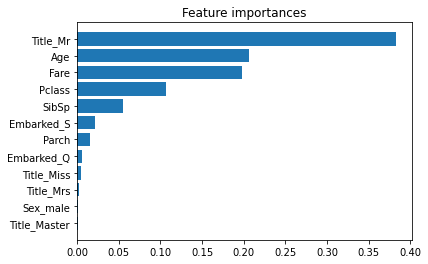

In [14]:
sorted_idx =RFR.feature_importances_.argsort()

plt.barh(X_train1.columns[sorted_idx],RFR.feature_importances_[sorted_idx])
plt.title("Feature importances")

### 2.2. Heatmap of Correlation
Next figure shows the Correlation between features by heatmap. The block which crosses Title_Mr and Sex_male is red which shows high correlation. Also you can see negative correlation between Fare and Pclass because higher class is more expensive.

Text(0.5, 1.0, 'Heatmap\xa0of all the Features')

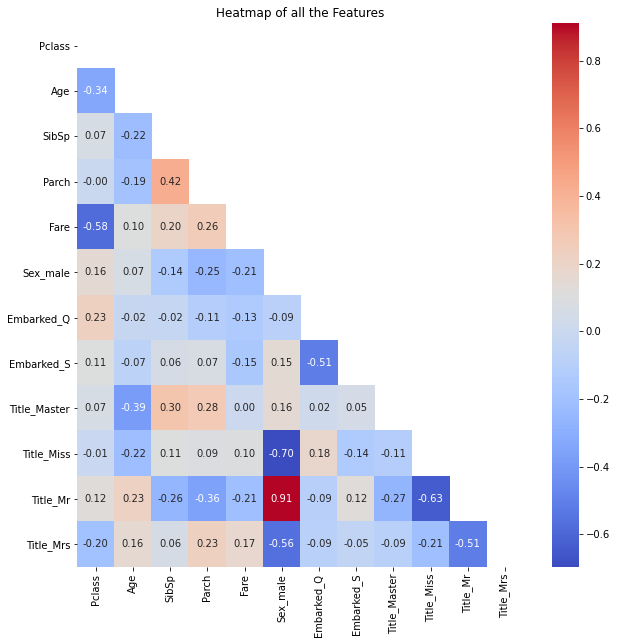

In [15]:
import seaborn as sns
plt.subplots(figsize=(10,10))
matrix = np.triu(X_train1.corr())
sns.heatmap(X_train1.corr(), annot=True, mask=matrix, cmap='coolwarm',fmt='.2f')
plt.title("Heatmap of all the Features")

## 3. Interprit Model by Shap

In [16]:
import shap

shap.initjs() #notebook内でJavascriptを動かすためのおまじない

explainer = shap.Explainer(RFR, X_test1)
shap_values = explainer(X_test1)

### 3.1. Global bar plot
Global bar plot shows the feature which affects to the target most. The graph shows Title_Mr affects to target most and Pclass follows.
This is consistent with the fact that sex is one factor of surviving on the data "Titanic". However, this graph can't tell if men or women tend to live more.

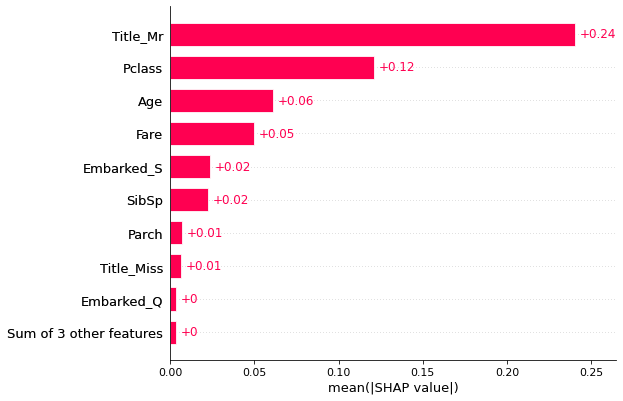

In [17]:
#Global bar plot(https://shap.readthedocs.io/en/latest/example_notebooks/api_examples/plots/bar.html)
shap.plots.bar(shap_values)

### 3.2. Beeswarm plot
This graph shows more information than Grobal bar plot.

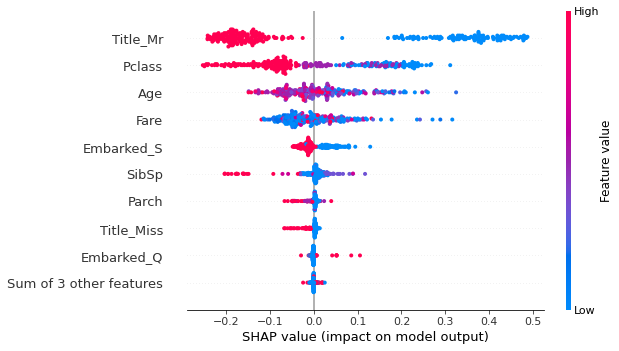

In [18]:
# https://shap.readthedocs.io/en/latest/example_notebooks/api_examples/plots/beeswarm.html
shap.plots.beeswarm(shap_values)

### 3.3. Local bar plot
Local bar plot explains each indivisual instance.

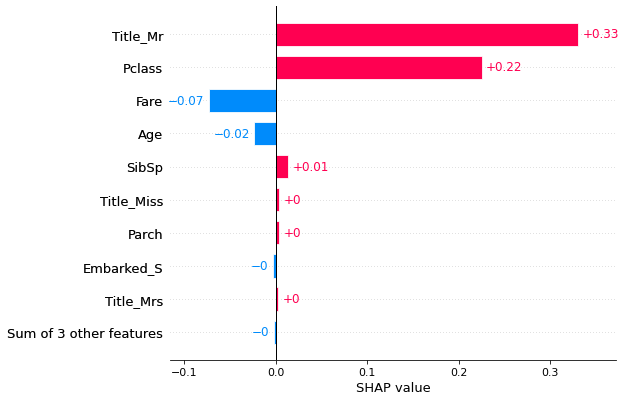

In [19]:
#Local bar plot https://shap.readthedocs.io/en/latest/example_notebooks/api_examples/plots/bar.html#Local-bar-plot
shap.plots.bar(shap_values[0])

### 3.4. Waterfall plot
Like Local bar plot, Waterfall plot also explains each indivisual instance. Additionally, this explains how the prediction is predicted by accumulating each features impact. Let's see the 1st instance of X_test1. The prediction is 0.81 which is close to 1. Since 1 means Suvivied and 0 means dead, this instance highly survived. We will see which feature impacts to the result by using Waterfall plot.

From the figure below, you can see Title_Mr=0 (female) and Pclass=1(staying at 1st class) push up the value by 0.81 from average(=0.33).
This is consistent with the fact that female survived more than male did.

In [20]:
RFR.predict(X_test1)[0]

0.81

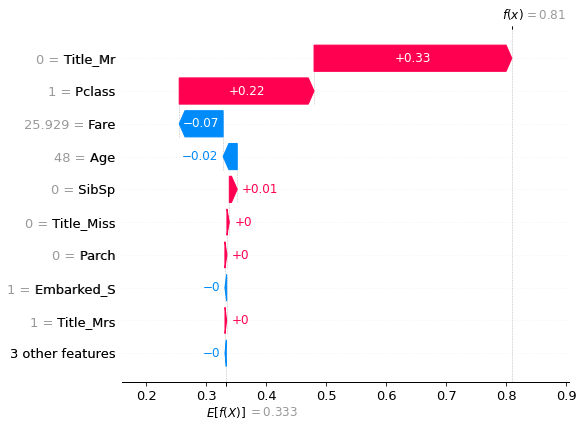

In [21]:
#waterfall plot https://shap.readthedocs.io/en/latest/example_notebooks/api_examples/plots/waterfall.html
shap.plots.waterfall(shap_values[0])

The second instance likely to die because of Title_Mr=1(male) and Pclass=3(staying at 3rd class)

In [22]:
RFR.predict(X_test1)[1]

0.0

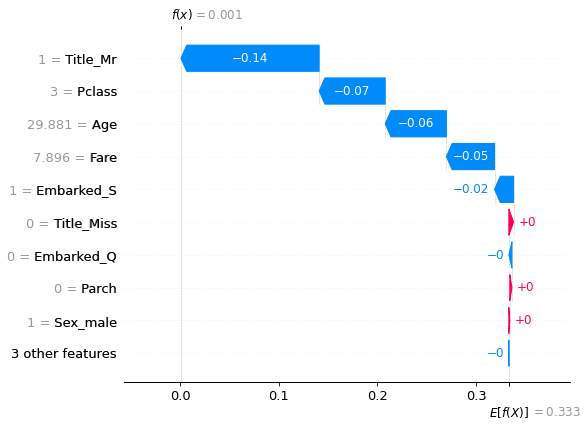

In [23]:
#waterfall plot https://shap.readthedocs.io/en/latest/example_notebooks/api_examples/plots/waterfall.html
shap.plots.waterfall(shap_values[1])

### 3.5. Heatmap plot

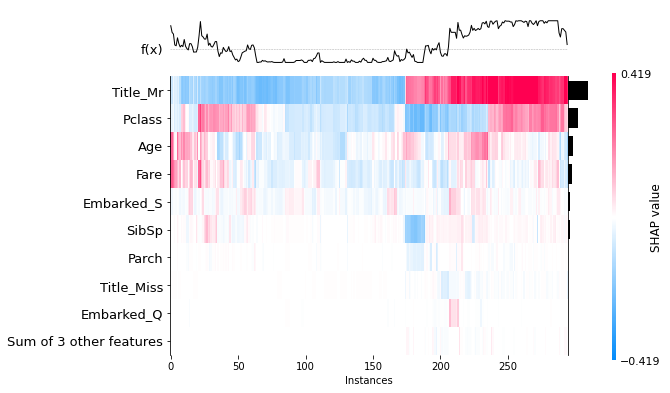

In [24]:
#heatmap plot (https://shap.readthedocs.io/en/latest/example_notebooks/api_examples/plots/heatmap.html)
shap.plots.heatmap(shap_values)

### 4. Conclusion
In this notebook, we looked through how the shap explains the model with using the data "Titanic" and we understand several points below.
- Shap can explain the model with a few programs and has several features which you can use for different purposes of analysis. 
- Shap explains not only the behavior of the model but also realation between each feature and predictsion on each instance level